In [1]:
import os
import csv
import pandas as pd
import numpy as np
from scipy.sparse import vstack, hstack
from scipy.sparse import csr_matrix
import re
from string import digits

import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tag.stanford import StanfordNERTagger
from nltk.stem import WordNetLemmatizer

from stop_words import get_stop_words

from gensim.models.phrases import Phrases



from matplotlib import pyplot as plt

In [2]:
def clean_up(line):
## non togliamo gli hashtag --> #

    line = line \
        .replace('<i>', '').replace('</i>', '').replace('...', '') \
        .replace(',', '').replace('.','').replace(';','').replace('?','').replace('!','')\
        .replace('[', "").replace(']', "").replace('=', '') \
        .replace('(', '').replace(')', '').replace('$', '').replace('  ', ' ') \
        .replace('"', '').replace(':', '').replace('{', '').replace('-', '') \
        .replace('}', '').replace('@', '').replace('&','') \
        .replace('^','').replace('*','').replace('+','').replace('/','') \
        .replace('\\','').replace('|','').replace('%','').replace("#", " #") \
        .replace('\"','').replace('  ', ' ').replace('    ', ' ') # .replace('\'',' ').replace('_', '')

    try:
        for f in set(re.findall('\<.*?\>', line)): # tolgo roba come <font color808080>agatha</font> e lascio agatha
            line = line.replace(f, '')
            line = line.replace('<', '').replace('>', '')

    except:
        line = line.strip()

    try:
        line = re.sub('font color\d*\w*\d', '', line) # tolgo roba come font color8080dr80
    except:
        line = line.strip()
    try:
        line = re.sub('font color\d*', '', line) # tolgo roba come font color8080
    except:
        line = line.strip()
    try:
        for d in re.findall('\d', line):
            line = line.replace(str(d[0]), "")

    except:
        line = line.strip()

    #return unicode(line.strip().replace('  ',' '), 'ascii', 'ignore')
    return line.strip().replace('  ',' ')


def clean_text(text_column, stopwords_list):

    tweets_text               = [str(tweet).lower() for tweet in text_column]
    tweet_puliti              = list(map(lambda x: clean_up(str(x)), tweets_text))
    tweet_puliti_tokenized_   = [token for token in [tweet.split() for tweet in tweet_puliti]]

    bigram_model = Phrases(tweet_puliti_tokenized_) # to create the bigrams

    tweet_puliti_tokenized_bigram = []
    for unigram_sentence in tweet_puliti_tokenized_:
            tweet_puliti_tokenized_bigram.append(bigram_model[unigram_sentence])   # apply the trained model to a sentence

    tweet_puliti_tokenized_bigram_no_stopwords = [[word for word in tweet if word not in stopwords] for tweet in tweet_puliti_tokenized_bigram]

    return tweet_puliti_tokenized_bigram_no_stopwords


def lemmatizer_custom(doc):
    res = ' '.join(map(lambda x: lemmatizer_nltk.lemmatize(x, get_wordnet_pos(x)), doc))
    return res

In [3]:
df = pd.read_csv("SanremoTweet.csv", sep = "|", header= 0, error_bad_lines=False)
df = df.drop_duplicates(subset="tweet_text")
df = df.sort_values('timestamp').reset_index(drop=True)


stopwords = get_stop_words('it')
df['id'] = [str(id) for id in list(range(df.shape[0]))]

In [4]:
tweets_text               = [str(tweet).lower() for tweet in df['tweet_text']]
tweet_puliti              = list(map(lambda x: clean_up(str(x)), tweets_text))
tweet_puliti_tokenized_   = [token for token in [tweet.split() for tweet in tweet_puliti]]


In [6]:
df

,hashtag,timestamp,tweet_text,user_name,id
0,#Sanremo,2020-02-05 20:29:38,Ma anche stasera c' #Sanremo? Veramente? Allor...,DonatoColelli,0
1,#Sanremo,2020-02-05 20:29:38,"Amadeus: Senza nessuna ipocrisia, se fabrizio ...",SuperGuidaTV,1
2,#Sanremo,2020-02-05 20:29:42,#Sanremo2020: #Fiorello si veste da #MariaDeFi...,GlobalShowGSRa1,2
3,#Sanremo,2020-02-05 20:30:00,"Con ""OMG-TR"", cantano 600 CV, dirige l'orchest...",Nissanitalia,3
4,#Sanremo,2020-02-05 20:30:02,"Non diciamo sciocchezze, non gli hanno mai fat...",GiusDello,4
...,...,...,...,...,...
24788,#Sanremo,2020-02-16 22:43:04,Il mistero del post scritto e poi cancellato s...,GabrieleVilla77,24788
24789,#Sanremo,2020-02-16 22:52:25,"La dimostrazione che #Morgan un artista vero, ...",percheiovalgo,24789
24790,#Sanremo,2020-02-16 22:55:55,domenica per me significa duetto canoro con mi...,ildiariodiHarv,24790
24791,#Sanremo,2020-02-16 23:45:51,"Pensate che quello ""strano"" dei @bluvertigo er...",simonecamuncoli,24791


In [5]:
nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()
t   = tweet_puliti[112]
sia.polarity_scores(t)

list_neg  = []
list_neu  = []
list_pos  = []
list_comp = []

for t in tweet_puliti:

    polarity = sia.polarity_scores(t)

    list_neg.append(polarity["neg"])
    list_pos.append(polarity["pos"])
    list_neu.append(polarity["neu"])
    list_comp.append(polarity["compound"])


df_text_sentiment = pd.DataFrame({"id" : [str(id) for id in list(range(len(tweet_puliti)))],
                                "tweet_puliti" : tweet_puliti,
                                  "negative" : list_neg,
                                  "positive" : list_pos,
                                  "neutral" : list_neu,
                                  "compound" : list_comp})
df_text_sentiment = pd.merge(left=df, right=df_text_sentiment, how="inner", on="id")







[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [6]:
df_text_sentiment

,hashtag,timestamp,tweet_text,user_name,id,tweet_puliti,negative,positive,neutral,compound
0,#Sanremo,2020-02-05 20:29:38,Ma anche stasera c' #Sanremo? Veramente? Allor...,DonatoColelli,0,ma anche stasera c' #sanremo veramente allora ...,0.0,0.000,1.000,0.0000
1,#Sanremo,2020-02-05 20:29:38,"Amadeus: Senza nessuna ipocrisia, se fabrizio ...",SuperGuidaTV,1,amadeus senza nessuna ipocrisia se fabrizio ci...,0.0,0.138,0.862,0.4939
2,#Sanremo,2020-02-05 20:29:42,#Sanremo2020: #Fiorello si veste da #MariaDeFi...,GlobalShowGSRa1,2,#sanremo #fiorello si veste da #mariadefilippi...,0.0,0.000,1.000,0.0000
3,#Sanremo,2020-02-05 20:30:00,"Con ""OMG-TR"", cantano 600 CV, dirige l'orchest...",Nissanitalia,3,con omgtr cantano cv dirige l'orchestra #nissa...,0.0,0.000,1.000,0.0000
4,#Sanremo,2020-02-05 20:30:02,"Non diciamo sciocchezze, non gli hanno mai fat...",GiusDello,4,non diciamo sciocchezze non gli hanno mai fatt...,0.0,0.122,0.878,0.4939
...,...,...,...,...,...,...,...,...,...,...
24788,#Sanremo,2020-02-16 22:43:04,Il mistero del post scritto e poi cancellato s...,GabrieleVilla77,24788,il mistero del post scritto e poi cancellato s...,0.0,0.091,0.909,0.3400
24789,#Sanremo,2020-02-16 22:52:25,"La dimostrazione che #Morgan un artista vero, ...",percheiovalgo,24789,la dimostrazione che #morgan un artista vero d...,0.0,0.000,1.000,0.0000
24790,#Sanremo,2020-02-16 22:55:55,domenica per me significa duetto canoro con mi...,ildiariodiHarv,24790,domenica per me significa duetto canoro con mi...,0.0,0.000,1.000,0.0000
24791,#Sanremo,2020-02-16 23:45:51,"Pensate che quello ""strano"" dei @bluvertigo er...",simonecamuncoli,24791,pensate che quello strano dei bluvertigo era a...,0.0,0.000,1.000,0.0000


In [10]:
s= [df_text_sentiment['positive'].sum(),
    df_text_sentiment['negative'].sum(),
    df_text_sentiment['neutral'].sum(),
    df_text_sentiment['compound'].sum()]
s

[730.8279999999999, 341.60800000000006, 23719.557, 993.1885000000001]

(array([4.0000e+00, 4.0000e+00, 9.0000e+00, 1.0000e+01, 4.0000e+00,
        2.4000e+01, 3.2000e+01, 1.6000e+01, 1.9000e+01, 1.6000e+01,
        2.1800e+02, 5.9000e+01, 2.7000e+01, 2.3600e+02, 2.7000e+01,
        1.3000e+01, 2.3000e+01, 2.4000e+01, 7.7400e+02, 1.8500e+02,
        1.8000e+01, 2.8000e+01, 1.2000e+01, 5.6000e+01, 9.0000e+00,
        5.9000e+01, 1.1000e+01, 9.0000e+00, 1.8746e+04, 1.3300e+02,
        3.4000e+01, 2.5000e+01, 1.6000e+01, 1.3000e+01, 2.5200e+02,
        1.8000e+01, 5.9000e+01, 1.9600e+02, 4.6000e+01, 1.4260e+03,
        2.9000e+01, 7.0000e+01, 5.0000e+01, 1.8000e+01, 9.6600e+02,
        4.1000e+01, 5.2000e+01, 2.5600e+02, 4.2000e+01, 2.1000e+01,
        1.2500e+02, 4.2000e+01, 6.7000e+01, 4.0000e+01, 3.0000e+01,
        1.3000e+01, 1.5000e+01, 1.0000e+01, 1.1000e+01, 5.0000e+00]),
 array([-0.886   , -0.854725, -0.82345 , -0.792175, -0.7609  , -0.729625,
        -0.69835 , -0.667075, -0.6358  , -0.604525, -0.57325 , -0.541975,
        -0.5107  , -0.479425, -0.4

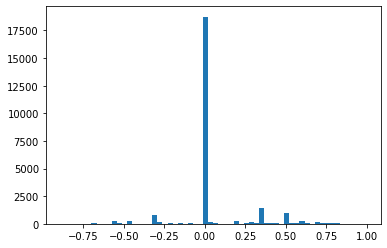

In [12]:
plt.hist(df_text_sentiment['compound'], bins = 60)

(array([2.253e+04, 4.000e+00, 3.000e+00, 3.900e+01, 1.070e+02, 1.550e+02,
        1.630e+02, 1.580e+02, 1.930e+02, 1.780e+02, 1.550e+02, 1.310e+02,
        1.130e+02, 9.200e+01, 1.150e+02, 7.300e+01, 7.700e+01, 5.500e+01,
        6.600e+01, 3.800e+01, 4.900e+01, 4.000e+01, 5.000e+01, 1.500e+01,
        2.700e+01, 1.400e+01, 4.500e+01, 9.000e+00, 5.000e+00, 1.400e+01,
        1.400e+01, 3.000e+00, 1.200e+01, 1.000e+00, 3.000e+00, 5.000e+00,
        1.200e+01, 0.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 4.000e+00,
        2.000e+00, 3.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([0.        , 0.01168333, 0.02336667, 0.03505   , 0.04673333,
        0.05841667, 0.0701    , 0.08178333, 0.09346667, 0.10515   ,
        0.11683333, 0.12851667, 0.1402    , 0.15188333, 0.16356667,
        0.17525   , 0.18693333, 0.19861667, 0.2103    

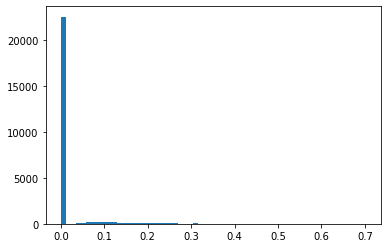

In [13]:
plt.hist(df_text_sentiment['negative'], bins = 60)

(array([2.0441e+04, 0.0000e+00, 1.9000e+01, 1.0200e+02, 2.5900e+02,
        2.5600e+02, 3.4000e+02, 3.5200e+02, 3.1000e+02, 3.0400e+02,
        3.2100e+02, 2.6200e+02, 2.3400e+02, 2.5400e+02, 1.6800e+02,
        1.7200e+02, 1.1200e+02, 1.6800e+02, 8.9000e+01, 9.0000e+01,
        2.4000e+01, 1.1100e+02, 2.2000e+01, 5.5000e+01, 3.7000e+01,
        4.4000e+01, 3.0000e+01, 3.2000e+01, 2.5000e+01, 1.2000e+01,
        2.0000e+01, 1.0000e+01, 2.9000e+01, 7.0000e+00, 8.0000e+00,
        1.2000e+01, 1.1000e+01, 4.0000e+00, 4.0000e+00, 4.0000e+00,
        7.0000e+00, 8.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00,
        5.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0.        , 0.01346667, 0.02693333, 0.0404    , 0.05386667,
        0.06733333, 0.0808    , 0.09426667, 0.10773333, 0.1212    ,
        0.13466667, 0.14813333, 0.1616    , 0.

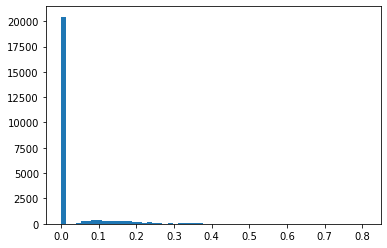

In [14]:
plt.hist(df_text_sentiment['positive'], bins = 60)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        6.0000e+00, 2.0000e+00, 4.0000e+00, 9.0000e+00, 1.0000e+00,
        1.0000e+01, 1.3000e+01, 1.3000e+01, 1.1000e+01, 1.0000e+01,
        1.7000e+01, 2.2000e+01, 1.7000e+01, 3.3000e+01, 3.2000e+01,
        2.9000e+01, 4.7000e+01, 5.2000e+01, 5.6000e+01, 7.0000e+01,
        7.7000e+01, 1.0900e+02, 1.6800e+02, 9.9000e+01, 1.7700e+02,
        1.9100e+02, 2.6400e+02, 2.8400e+02, 3.8700e+02, 5.4300e+02,
        3.4100e+02, 5.0700e+02, 5.6500e+02, 5.4200e+02, 5.3900e+02,
        3.9100e+02, 3.4200e+02, 6.1000e+01, 2.0000e+00, 1.8737e+04]),
 array([0.        , 0.01666667, 0.03333333, 0.05      , 0.06666667,
        0.08333333, 0.1       , 0.11666667, 0.13333333, 0.15      ,
        0.16666667, 0.18333333, 0.2       , 0.

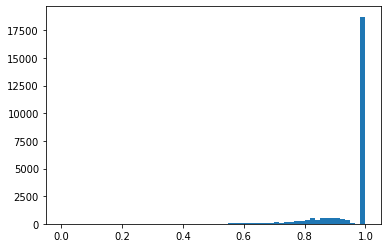

In [15]:
plt.hist(df_text_sentiment['neutral'], bins = 60)

In [11]:
artist = ['diodato','gabbani','pinguini','vibrazioni','piero','tosca','rancore','elodie','achille','levante','masini','elettra','morgan','bugo','anastasio']

scores={}
scores['artist']= artist
for i in artist:
    df_text_sentiment[i] = df_text_sentiment['tweet_puliti'].str.contains(i,flags=re.I,regex=True)

presenza=[]

pos_assoluta=[]
neg_assoluta=[]
comp_assoluta=[]



for i in artist:
    presenza.append(df_text_sentiment[i].sum())
    pos_assoluta.append((df_text_sentiment['positive']*df_text_sentiment[i]).sum())
    neg_assoluta.append((df_text_sentiment['negative']*df_text_sentiment[i]).sum())
    comp_assoluta.append((df_text_sentiment['compound']*df_text_sentiment[i]).sum())
    


scores_assoluti = pd.DataFrame({'artist': artist,
                     'presenza': presenza,
                     'pos_assoluta': pos_assoluta,
                     'neg_assoluta': neg_assoluta,
                     'comp_assoluta':comp_assoluta })
scores_assoluti= scores_assoluti.sort_values('comp_assoluta', ascending=False).reset_index(drop=True)
scores_assoluti

,artist,presenza,pos_assoluta,neg_assoluta,comp_assoluta
0,diodato,1449,70.257,14.368,151.4539
1,achille,1519,45.999,18.827,84.0699
2,morgan,1297,37.471,12.149,81.3863
3,bugo,1218,32.391,11.896,67.8726
4,elettra,2214,52.618,27.126,54.5713
5,gabbani,664,22.975,7.607,43.8542
6,pinguini,496,12.307,5.153,24.3039
7,rancore,509,19.038,7.070,22.3711
8,levante,412,12.022,5.958,16.7015
9,elodie,254,9.908,5.263,10.8290


In [51]:
sa=scores_assoluti.set_index('artist')
sa

,presenza,pos_assoluta,neg_assoluta,comp_assoluta
artist,,,,
diodato,1449,70.257,14.368,151.4539
achille,1519,45.999,18.827,84.0699
morgan,1297,37.471,12.149,81.3863
bugo,1218,32.391,11.896,67.8726
elettra,2214,52.618,27.126,54.5713
gabbani,664,22.975,7.607,43.8542
pinguini,496,12.307,5.153,24.3039
rancore,509,19.038,7.070,22.3711
levante,412,12.022,5.958,16.7015


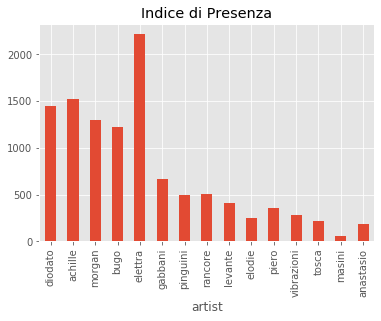

In [52]:
sa['presenza'].plot(kind='bar', title='Indice di Presenza')

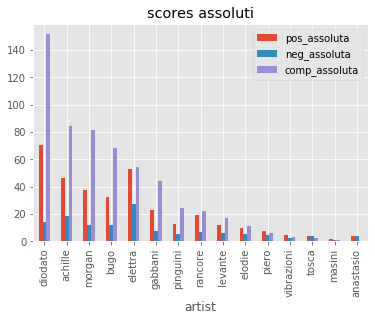

In [49]:
sa=sa.loc[:,'pos_assoluta':'comp_assoluta']
sa.plot(kind='bar', title='Scores Assoluti')

In [24]:
pos_relativa=[]
neg_relativa=[]
comp_relativa=[]

pos_relativa= scores_assoluti['pos_assoluta']/scores_assoluti['presenza']*100
neg_relativa= scores_assoluti['neg_assoluta']/scores_assoluti['presenza']*100
comp_relativa= scores_assoluti['comp_assoluta']/scores_assoluti['presenza']*100

scores_relativi = pd.DataFrame({'artist': artist,
                     'pos_relativa': pos_relativa,
                     'neg_relativa': neg_relativa,
                     'comp_relativa':comp_relativa })
scores_relativi= scores_relativi.sort_values('comp_relativa', ascending=False).reset_index(drop=True)
scores_relativi

,artist,pos_relativa,neg_relativa,comp_relativa
0,diodato,4.848654,0.991580,10.452305
1,tosca,3.460090,1.145633,6.604548
2,pinguini,2.889052,0.936700,6.274965
3,vibrazioni,2.659360,0.976683,5.572463
4,gabbani,3.028242,1.239434,5.534556
5,rancore,2.481250,1.038911,4.899980
6,elodie,3.740275,1.388998,4.395108
7,levante,3.900787,2.072047,4.263386
8,achille,2.917961,1.446117,4.053762
9,piero,2.376603,1.225203,2.464828


In [26]:
sr=scores_relativi.set_index('artist')
sr

,pos_relativa,neg_relativa,comp_relativa
artist,,,
diodato,4.848654,0.991580,10.452305
tosca,3.460090,1.145633,6.604548
pinguini,2.889052,0.936700,6.274965
vibrazioni,2.659360,0.976683,5.572463
gabbani,3.028242,1.239434,5.534556
rancore,2.481250,1.038911,4.899980
elodie,3.740275,1.388998,4.395108
levante,3.900787,2.072047,4.263386
achille,2.917961,1.446117,4.053762


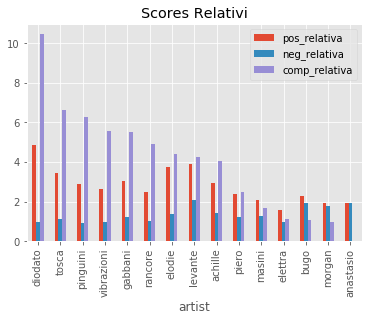

In [50]:
sr.plot(kind='bar', title='Scores Relativi')

In [7]:
ospiti = ['amedeus','diletta','ferro','benigni','ranieri','fiorello','capaldi','coez','zucchero','biagio']
ospiti_scores={}
ospiti_scores['ospiti']= ospiti
for i in ospiti:
    df_text_sentiment[i] = df_text_sentiment['tweet_puliti'].str.contains(i,flags=re.I,regex=True)

ospiti_presenza=[]

ospiti_pos_assoluta=[]
ospiti_neg_assoluta=[]
ospiti_comp_assoluta=[]



for i in ospiti:
    ospiti_presenza.append(df_text_sentiment[i].sum())
    ospiti_pos_assoluta.append((df_text_sentiment['positive']*df_text_sentiment[i]).sum())
    ospiti_neg_assoluta.append((df_text_sentiment['negative']*df_text_sentiment[i]).sum())
    ospiti_comp_assoluta.append((df_text_sentiment['compound']*df_text_sentiment[i]).sum())
    


ospiti_scores_assoluti = pd.DataFrame({'ospiti': ospiti,
                     'presenza': ospiti_presenza,
                     'pos_assoluta': ospiti_pos_assoluta,
                     'neg_assoluta': ospiti_neg_assoluta,
                     'comp_assoluta': ospiti_comp_assoluta })
ospiti_scores_assoluti= ospiti_scores_assoluti.sort_values('comp_assoluta', ascending=False).reset_index(drop=True)
ospiti_scores_assoluti

,ospiti,presenza,pos_assoluta,neg_assoluta,comp_assoluta
0,fiorello,717,22.736,7.185,51.0676
1,ferro,456,11.568,6.609,18.3708
2,ranieri,316,8.214,6.187,6.1544
3,biagio,175,5.463,3.302,5.7166
4,diletta,121,2.436,1.331,5.5087
5,benigni,44,2.316,0.722,4.9683
6,amedeus,17,1.316,0.310,3.3490
7,coez,12,1.199,0.000,3.2745
8,zucchero,64,1.460,1.412,-0.2146
9,capaldi,4,0.000,0.261,-0.7548


In [14]:
osa=ospiti_scores_assoluti.set_index('ospiti')
osa

,presenza,pos_assoluta,neg_assoluta,comp_assoluta
ospiti,,,,
fiorello,717,22.736,7.185,51.0676
ferro,456,11.568,6.609,18.3708
ranieri,316,8.214,6.187,6.1544
biagio,175,5.463,3.302,5.7166
diletta,121,2.436,1.331,5.5087
benigni,44,2.316,0.722,4.9683
amedeus,17,1.316,0.310,3.3490
coez,12,1.199,0.000,3.2745
zucchero,64,1.460,1.412,-0.2146


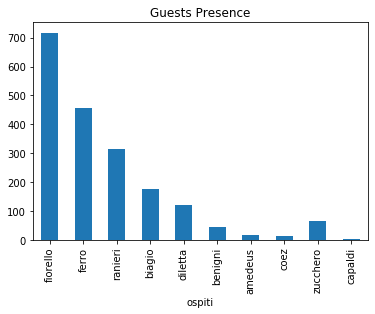

In [15]:
osa['presenza'].plot(kind='bar', title='Guests Presence')

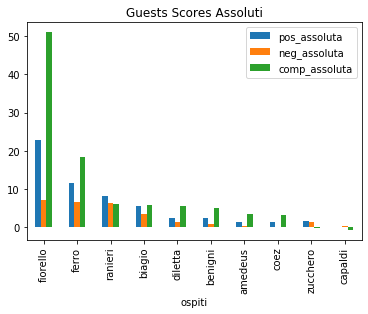

In [16]:
osa=osa.loc[:,'pos_assoluta':'comp_assoluta']
osa.plot(kind='bar', title='Guests Scores Assoluti')

In [8]:
ospiti_pos_relativa=[]
ospiti_neg_relativa=[]
ospiti_comp_relativa=[]

ospiti_pos_relativa= ospiti_scores_assoluti['pos_assoluta']/ospiti_scores_assoluti['presenza']*100
ospiti_neg_relativa= ospiti_scores_assoluti['neg_assoluta']/ospiti_scores_assoluti['presenza']*100
ospiti_comp_relativa= ospiti_scores_assoluti['comp_assoluta']/ospiti_scores_assoluti['presenza']*100

ospiti_scores_relativi = pd.DataFrame({'ospiti': ospiti,
                     'pos_relativa': ospiti_pos_relativa,
                     'neg_relativa': ospiti_neg_relativa,
                     'comp_relativa':ospiti_comp_relativa })
ospiti_scores_relativi= ospiti_scores_relativi.sort_values('comp_relativa', ascending=False).reset_index(drop=True)
ospiti_scores_relativi

,ospiti,pos_relativa,neg_relativa,comp_relativa
0,coez,9.991667,0.000000,27.287500
1,capaldi,7.741176,1.823529,19.700000
2,fiorello,5.263636,1.640909,11.291591
3,amedeus,3.170990,1.002092,7.122399
4,ranieri,2.013223,1.100000,4.552645
5,diletta,2.536842,1.449342,4.028684
6,benigni,3.121714,1.886857,3.266629
7,ferro,2.599367,1.957911,1.947595
8,zucchero,2.281250,2.206250,-0.335312
9,biagio,0.000000,6.525000,-18.870000


In [10]:
osr=ospiti_scores_relativi.set_index('ospiti')
osr

,pos_relativa,neg_relativa,comp_relativa
ospiti,,,
coez,9.991667,0.000000,27.287500
capaldi,7.741176,1.823529,19.700000
fiorello,5.263636,1.640909,11.291591
amedeus,3.170990,1.002092,7.122399
ranieri,2.013223,1.100000,4.552645
diletta,2.536842,1.449342,4.028684
benigni,3.121714,1.886857,3.266629
ferro,2.599367,1.957911,1.947595
zucchero,2.281250,2.206250,-0.335312


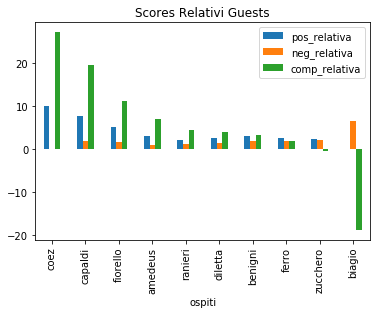

In [12]:
osr.plot(kind='bar', title='Scores Relativi Guests')

,negative,positive,compound
timestamp,,,
2020-02-05 20:00:00,0.012004,0.024933,0.032461
2020-02-05 21:00:00,0.013767,0.026693,0.027566
2020-02-05 22:00:00,0.013857,0.018598,0.011406
2020-02-05 23:00:00,0.016036,0.025135,0.022159
2020-02-06 00:00:00,NaN,NaN,NaN
...,...,...,...
2020-02-16 19:00:00,0.012500,0.000000,-0.065375
2020-02-16 20:00:00,0.010280,0.000000,-0.038776
2020-02-16 21:00:00,0.009250,0.018200,0.018670
